## El objetivo de esta notebook es encontrar el mejor modelo para nuestro problema.

In [9]:
# librerias necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import pickle

- Levantamos el df que preprocesamos

In [2]:
df_estudiantes = pd.read_csv("../data/df_estudiantes.csv")
df_estudiantes.head()

,user_uuid,course_uuid,legajo,course_name,periodo,particion,fecha_mesa_epoch,nombre_examen,nota_parcial,nota_final_materia,aprobado,rango_nota,diferencia_notas,promedio_nota_parcial,std_nota_parcial,num_actividades,puntaje_total,num_tareas,mean_puntaje_tareas,dias_mean_antes_vencimiento
0,13df535e-065c-4593-98ea-5b1e29015b7d,09614210-fce2-48bc-93e3-bc4bd441fe00,834066QFF,Progressive homogeneous structure,1-2022,28,2022-05-06,PRIMER PARCIAL(20),8.0,9.0,1,alto,1.0,9.00,1.41,0.0,575.0,8,82.14,1.71
1,13df535e-065c-4593-98ea-5b1e29015b7d,09614210-fce2-48bc-93e3-bc4bd441fe00,834066QFF,Progressive homogeneous structure,1-2022,38,2022-05-31,SEGUNDO PARCIAL(20),10.0,9.0,1,alto,-1.0,9.00,1.41,1.0,575.0,8,82.14,1.71
2,8289fbcb-a999-4b5b-8d7e-a4ea0fe477d5,14d11dfe-01d7-4c8a-8489-59cce7e2d051,730281VXM,Switchable radical service-desk,1-2022,21,2022-04-01,PRIMER PARCIAL(20),4.0,5.0,1,medio,1.0,4.75,0.50,0.0,557.5,8,79.64,25.00
3,8289fbcb-a999-4b5b-8d7e-a4ea0fe477d5,14d11dfe-01d7-4c8a-8489-59cce7e2d051,730281VXM,Switchable radical service-desk,1-2022,45,2022-05-10,SEGUNDO PARCIAL(20),5.0,5.0,1,medio,0.0,4.75,0.50,2.0,557.5,8,79.64,25.00
4,8289fbcb-a999-4b5b-8d7e-a4ea0fe477d5,14d11dfe-01d7-4c8a-8489-59cce7e2d051,730281VXM,Switchable radical service-desk,1-2022,45,2022-05-10,SEGUNDO PARCIAL(20),5.0,5.0,1,medio,0.0,4.75,0.50,2.0,557.5,8,79.64,25.00


- Seleccionar columnas relevantes para el entrenamiento 

In [3]:
features = [
        "nombre_examen","course_name", "nota_parcial", "promedio_nota_parcial", "std_nota_parcial", "num_actividades",
        "puntaje_total", "num_tareas", "mean_puntaje_tareas",
        "dias_mean_antes_vencimiento"
]
target = "aprobado"
numeric_features = ["nota_parcial", "promedio_nota_parcial", "std_nota_parcial", "num_actividades", "puntaje_total", 
                    "num_tareas", "mean_puntaje_tareas", "dias_mean_antes_vencimiento"]
categorical_features = ["course_name", "nombre_examen"]


In [4]:
X = df_estudiantes[features]
y = df_estudiantes[target]

- Dividimos los datos en tres conjuntos (entrenamiento, validación y test) manteniendo la proporción de clases en cada uno para asegurar una evaluación robusta del modelo

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

- Creamos un preprocesador que maneja características numéricas (imputando valores faltantes con la media y escalando) y categóricas (imputando con la moda y codificando en one-hot) por separado

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())]), 
            numeric_features),
        
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))]), 
            categorical_features)
    ])

- Definimos una variedad de modelos de clasificación y sus respectivas grillas de hiperparámetros para optimizar su rendimiento mediante búsqueda exhaustiva (GridSearchCV)

In [7]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=100),
    "Decision Tree": DecisionTreeClassifier(random_state=100),
    "Random Forest": RandomForestClassifier(random_state=100),
    "Gradient Boosting": GradientBoostingClassifier(random_state=100),
    "SVM": SVC(probability=True, random_state=100),
    "XGBoost": XGBClassifier(random_state=100, eval_metric="logloss")  
}

param_grids = {
    "Logistic Regression": {"classifier__C": [0.001, 0.01, 0.1, 1, 10, 100]},
    "Decision Tree": {"classifier__max_depth": [None, 3, 10],
                    "classifier__min_samples_split": [2, 5, 10], 
                    "classifier__min_samples_leaf": [1, 2, 4]},
    "Random Forest": {"classifier__n_estimators": [10, 50, 200], 
                    "classifier__max_depth": [None, 3, 10],
                    "classifier__min_samples_split": [2, 5, 10], 
                    "classifier__min_samples_leaf": [1, 2, 4]}, 
    "Gradient Boosting": {"classifier__n_estimators": [50, 100, 200], 
                        "classifier__learning_rate": [0.01, 0.1, 0.2],  
                        "classifier__max_depth": [3, 7, 11]}, 
    "SVM": {"classifier__C": [0.1, 1, 10], 
            "classifier__kernel": ["linear", "rbf"],
            "classifier__gamma": ["scale", "auto"]}, 
    "XGBoost": {"classifier__n_estimators": [50, 100, 150],
                "classifier__learning_rate": [0.01, 0.05, 0.1],
                "classifier__max_depth": [9, 11, 13],
                "classifier__subsample": [0.8, 0.9, 1.0],
                "classifier__colsample_bytree": [0.7, 0.85, 1.0]}  
}

- Para cada modelo, realizamos una busqueda de hiperparametros utilizando validacion cruzada para encontrar la mejor combinación y evaluar su rendimiento en el conjunto de validación, almacenando el mejor modelo para cada uno

In [8]:
best_models = {}
for name, model in models.items():

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring="roc_auc")


    grid_search.fit(X_train, y_train)

    print(f"Mejores parámetros para {name}: {grid_search.best_params_}")
    print(f"Mejor AUC-ROC para {name}: {grid_search.best_score_}")

    y_pred = grid_search.predict(X_valid)
    y_prob = grid_search.predict_proba(X_valid)[:, 1]


    print("Reporte de Clasificación en Validación:")
    print(classification_report(y_valid, y_pred))
    print("AUC-ROC en Validación:", roc_auc_score(y_valid, y_prob))
    print("----") 

    best_models[name] = grid_search.best_estimator_

Mejores parámetros para Logistic Regression: {'classifier__C': 10}
Mejor AUC-ROC para Logistic Regression: 0.9582519265452986
Reporte de Clasificación en Validación:
              precision    recall  f1-score   support

           0       0.85      0.58      0.69        57
           1       0.98      0.99      0.99       994

    accuracy                           0.97      1051
   macro avg       0.91      0.79      0.84      1051
weighted avg       0.97      0.97      0.97      1051

AUC-ROC en Validación: 0.9444738607081082
----
Mejores parámetros para Decision Tree: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10}
Mejor AUC-ROC para Decision Tree: 0.9173338036530845
Reporte de Clasificación en Validación:
              precision    recall  f1-score   support

           0       0.80      0.72      0.76        57
           1       0.98      0.99      0.99       994

    accuracy                           0.98      1051
   mac

Elegí XGBoost en lugar de Gradient Boosting por su mayor velocidad y potencial de ajuste fino, cruciales en aplicaciones donde el tiempo de entrenamiento y la optimización son importantes, a pesar de que ambos modelos mostraron un rendimiento excelente.

In [10]:
best_rf_model = best_models["XGBoost"]

In [17]:
y_pred = best_rf_model.predict(X_valid)
y_prob = best_rf_model.predict_proba(X_valid)[:, 1]


print("Reporte de Clasificación en Validación:")
print(classification_report(y_valid, y_pred))
print("AUC-ROC en Validación:", roc_auc_score(y_valid, y_prob))
print("----") 

Reporte de Clasificación en Validación:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87        57
           1       0.99      1.00      0.99       994

    accuracy                           0.99      1051
   macro avg       0.96      0.90      0.93      1051
weighted avg       0.99      0.99      0.99      1051

AUC-ROC en Validación: 0.9728899714073918
----


Visualizamos el rendimiento del modelo en el conjunto de validación mediante una matriz de confusión (para ver la distribución de las predicciones correctas e incorrectas) y una curva ROC (para evaluar la capacidad de discriminación del modelo entre las clases)

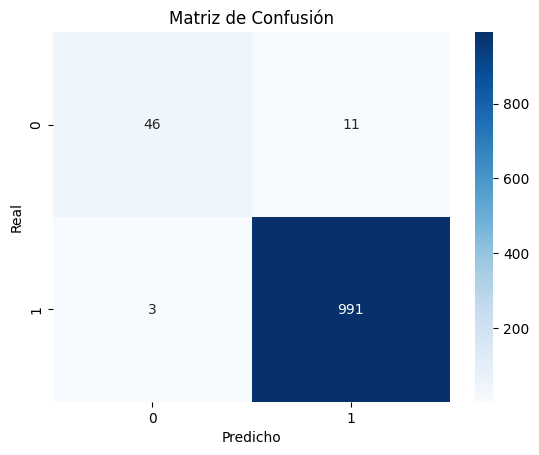

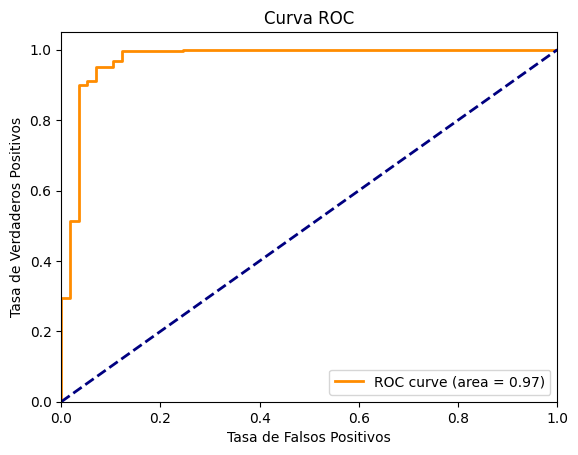

In [19]:
cm = confusion_matrix(y_valid, y_pred) 
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

fpr, tpr, thresholds = roc_curve(y_valid, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

- Misma logica que el grafico anterior pero para el conjunto de test

In [11]:
# Realiza predicciones en el conjunto de test
y_pred_test = best_rf_model.predict(X_test)
y_prob_test = best_rf_model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

# Evalúa el rendimiento utilizando las métricas que consideres relevantes
print("Reporte de Clasificación en Test:")
print(classification_report(y_test, y_pred_test))
print("AUC-ROC en Test:", roc_auc_score(y_test, y_prob_test))


Reporte de Clasificación en Test:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87        58
           1       0.99      1.00      0.99       994

    accuracy                           0.99      1052
   macro avg       0.98      0.89      0.93      1052
weighted avg       0.99      0.99      0.99      1052

AUC-ROC en Test: 0.9782488031638105


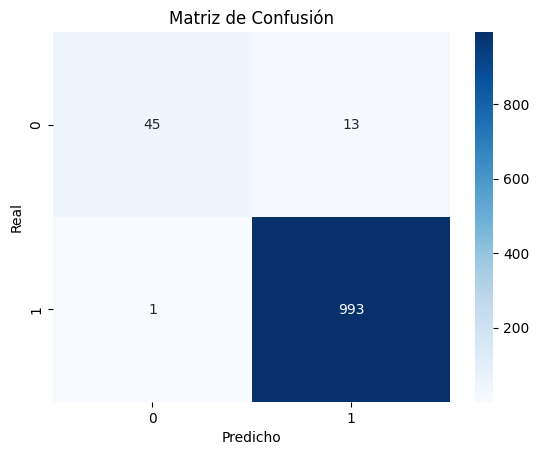

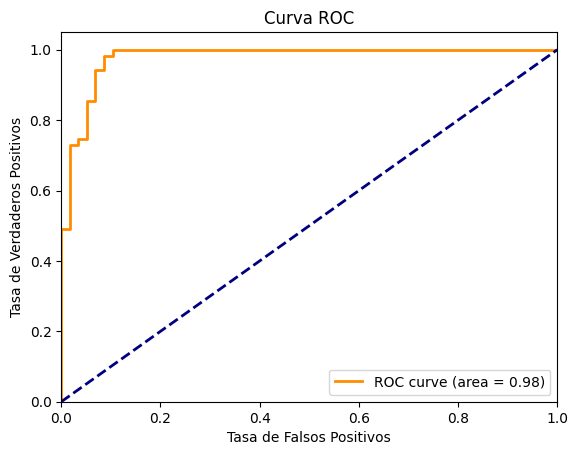

In [16]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test) 
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")

plt.show()

- Reentrenamos el mejor modelo utilizando todos los datos disponibles para maximizar su capacidad predictiva

In [20]:
X_all = pd.concat([X_train, X_valid, X_test])
y_all = pd.concat([y_train, y_valid, y_test])

# Reentrenar el mejor modelo con todos los datos
best_rf_model.fit(X_all, y_all)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['nota_parcial',
                                                   'promedio_nota_parcial',
                                                   'std_nota_parcial',
                                                   'num_actividades',
                                                   'puntaje_total',
                                                   'num_tareas',
                                                   'mean_puntaje_tareas',
                                                   'dias_mean_antes_vencimiento']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImput...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=13, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=150, n_jobs=None,
                               num_parallel_tree=None, random_state=100, ...))])

In [21]:
with open("../models/model_xgboost.pkl", "wb") as f:
    pickle.dump(best_rf_model, f)

**Conclusión**

En este análisis, exploramos varios modelos de clasificación. Después de una rigurosa búsqueda de hiperparámetros y evaluación en un conjunto de validación, el modelo **XGBoost** demostró el mejor rendimiento, logrando un AUC-ROC de 0.9728

Este modelo final, reentrenado con todos los datos disponibles, está listo para ser implementado en producción o para realizar nuevas predicciones.

**Posibles próximos pasos:**

* Recopilar más datos para mejorar aún más el rendimiento del modelo.
* Continuar explorando técnicas de ingeniería de características para extraer información adicional de los datos existentes.
* Considerar el uso de modelos de aprendizaje profundo si se dispone de suficientes datos y recursos computacionales.
* Implementar el modelo en un entorno de producción y monitorear su rendimiento a lo largo del tiempo.

Este análisis proporciona una base sólida para continuar con la mejora del proyecto.

Otra opcion es la de tener en cuenta la prediccion en diferentes etapas, se podrian entrenar modelos separados para diferentes momentos del curso

- modelo temprano: predice la nota final al principio, usando solo datos iniciales
- modelo intermedio: predice la nota final a mitad del curso, incorporando mas informacion
- modelo final: predice la nota final cerca del examen, con todos los datos disponibles